In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd

import glob as gb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D ,LeakyReLU

In [ ]:
## Define the directories for training, testing, and validation
train_directory = '/content/drive/MyDrive/ISIC2018/train'
test_directory = '/content/drive/MyDrive/ISIC2018/test'
valid_directory = '/content/drive/MyDrive/ISIC2018/validation'

In [ ]:

IMG_SIZE = (299, 299)  # define resolution (299,299) /(224,224)
BATCH_SIZE = 128

In [ ]:
# Create TensorFlow datasets for training, testing, and validation
#you can customize parameters as per dataset
train_dataset = image_dataset_from_directory(
    train_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

test_dataset = image_dataset_from_directory(
    test_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

valid_dataset = image_dataset_from_directory(
    valid_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)


Found 5200 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [ ]:
# Optional: You can also specify the class names if you have a specific order for your classes
class_names = train_dataset.class_names

# Print class names
print("Class Names:", class_names)

Class Names: ['benign', 'malignant']


<ipython-input-7-692dc6d515a1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[ "0","1"], y=Dataset, palette="rocket")  ## change the class name


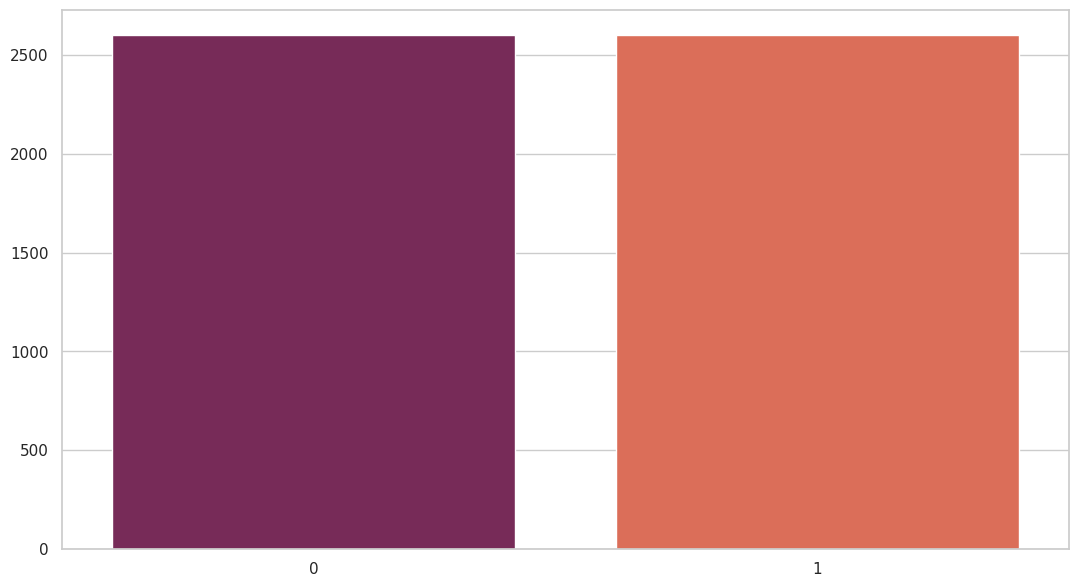

In [ ]:
#plot bar chart for demonstrating data size
sns.set_theme(style="whitegrid")
Dataset = []
for folder in os.listdir(train_directory):
    files = gb.glob(pathname=str(train_directory + "/" + folder +"/*.*"))
    Dataset.append(len(files))
plt.figure(figsize=(13,7))                    ## change the len size
sns.barplot(x=[ "0","1"], y=Dataset, palette="rocket")  ## change the class name
plt.show()

In [ ]:
base_learning_rate = 0.001 # prefferable lr is 0.0001 or 0.001
IMG_SHAPE = IMG_SIZE +(3,)

In [ ]:
## N.B:download the weights (imagenet/...) and model (Resnet50/ResNet100/InceptionV3...)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top= False, weights='imagenet')

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
type(base_model)
## N.B: changle the model name
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [ ]:
nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name)

Numbers of Layers = 175
conv5_block3_add
conv5_block3_out


In [ ]:
# iterate over first batch (32 image) in trainset
image_batch, label_batch = next(iter(train_dataset))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(128, 10, 10, 2048)


In [ ]:
def create_model( image_shape=IMG_SHAPE):
    ''' Define a tf.keras model for multi-class classification out of the *model name* (Resnet/Inception...) '''
    ##change the *model name*
    downloaded_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top= False, weights='imagenet')
    downloaded_model.trainable = True
    for layer in downloaded_model.layers[0 : 291]:
        layer.trainable = False

    inputs = tf.keras.Input(image_shape)
    x = preprocess_input(inputs)
    x = downloaded_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    prediction_layer = tf.keras.layers.Dense(7 ,activation = "softmax")   ## change the first parameter according to the class len
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    model.summary()
    return model

In [ ]:
## specify function name as model name
model = create_model(IMG_SHAPE)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 299, 299, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 299, 299, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [ ]:

## customize optimizer as Nadam or Adam
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
## set the path name as *dataset/Lr/optimizer_name/model_name*
model_filepath="/content/drive/MyDrive/ISIC2018/0.001/Nadam/resnet-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath = model_filepath ,
    monitor ='val_accuracy',
    mode = 'max' ,
    save_best_only =True ,
    verbose = 1
)

In [ ]:
#avoid random weight initialization do automatic if you can

total = 0
for i in range(0,len(Dataset )) :
    total +=Dataset [i]

weight_for_0 = (1 / Dataset [0]) * (total / 2.0)
weight_for_1 = (1 / Dataset [1]) * (total / 2.0)


class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.00
Weight for class 1: 1.00


In [ ]:
## change hyperparameter such as epoches
history = model.fit(train_dataset , verbose=2 , epochs=50 , class_weight=class_weight ,
                               validation_data=valid_dataset , use_multiprocessing= True, callbacks =[checkpoint])


Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to /content/drive/MyDrive/ISIC2018/0.001/Nadam/resnet50-01-0.7000.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 - 171s - loss: 0.9472 - accuracy: 0.5531 - val_loss: 0.6086 - val_accuracy: 0.7000 - 171s/epoch - 4s/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.70000 to 0.77000, saving model to /content/drive/MyDrive/ISIC2018/0.001/Nadam/resnet50-02-0.7700.hdf5
41/41 - 164s - loss: 0.6385 - accuracy: 0.6763 - val_loss: 0.5458 - val_accuracy: 0.7700 - 164s/epoch - 4s/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.77000 to 0.81000, saving model to /content/drive/MyDrive/ISIC2018/0.001/Nadam/resnet50-03-0.8100.hdf5
41/41 - 165s - loss: 0.5599 - accuracy: 0.7213 - val_loss: 0.5118 - val_accuracy: 0.8100 - 165s/epoch - 4s/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.81000
41/41 - 163s - loss: 0.5159 - accuracy: 0.7404 - val_loss: 0.5348 - val_accuracy: 0.8100 - 163s/epoch - 4s/step
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.81000
41/41 - 164s - loss: 0.4946 - accuracy: 0.7500 - val_loss: 0.5549 - val_accuracy: 0.7700 - 164s/epoch - 4s/step
Epoch 6/50

In [ ]:
## change hyperparameter such as epoches
history = model.fit(train_dataset , verbose=2 , epochs=30 , class_weight=class_weight ,
                               validation_data=valid_dataset , use_multiprocessing= True, callbacks =[checkpoint])

import pickle

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.68000, saving model to /content/drive/MyDrive/ISIC2018/0.001/Nadam/resnet-01-0.6800.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 - 271s - loss: 0.9472 - accuracy: 0.5531 - val_loss: 0.5805 - val_accuracy: 0.6800 - 271s/epoch - 7s/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.68000 to 0.74000, saving model to /content/drive/MyDrive/ISIC2018/0.001/Nadam/resnet-02-0.7400.hdf5
41/41 - 169s - loss: 0.6491 - accuracy: 0.6767 - val_loss: 0.5345 - val_accuracy: 0.7400 - 169s/epoch - 4s/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.74000 to 0.76000, saving model to /content/drive/MyDrive/ISIC2018/0.001/Nadam/resnet-03-0.7600.hdf5
41/41 - 168s - loss: 0.5644 - accuracy: 0.7129 - val_loss: 0.5059 - val_accuracy: 0.7600 - 168s/epoch - 4s/step
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.76000
41/41 - 169s - loss: 0.5169 - accuracy: 0.7437 - val_loss: 0.5638 - val_accuracy: 0.7400 - 169s/epoch - 4s/step
Epoch 5/30

Epoch 5: val_accuracy improved from 0.76000 to 0.77000, saving model to /content/drive/MyDrive/ISIC2018/0.001/Nadam/resnet-05-0.7700.hdf5
41/41 - 169s - loss: 0.4950 - accuracy:

In [ ]:
model.evaluate(test_dataset , verbose = 1)

8/8 [==============================] - 75s 4s/step - loss: 0.5442 - accuracy: 0.7210


[0.5441862940788269, 0.7210000157356262]

1/1 [==============================] - 0s 102ms/step


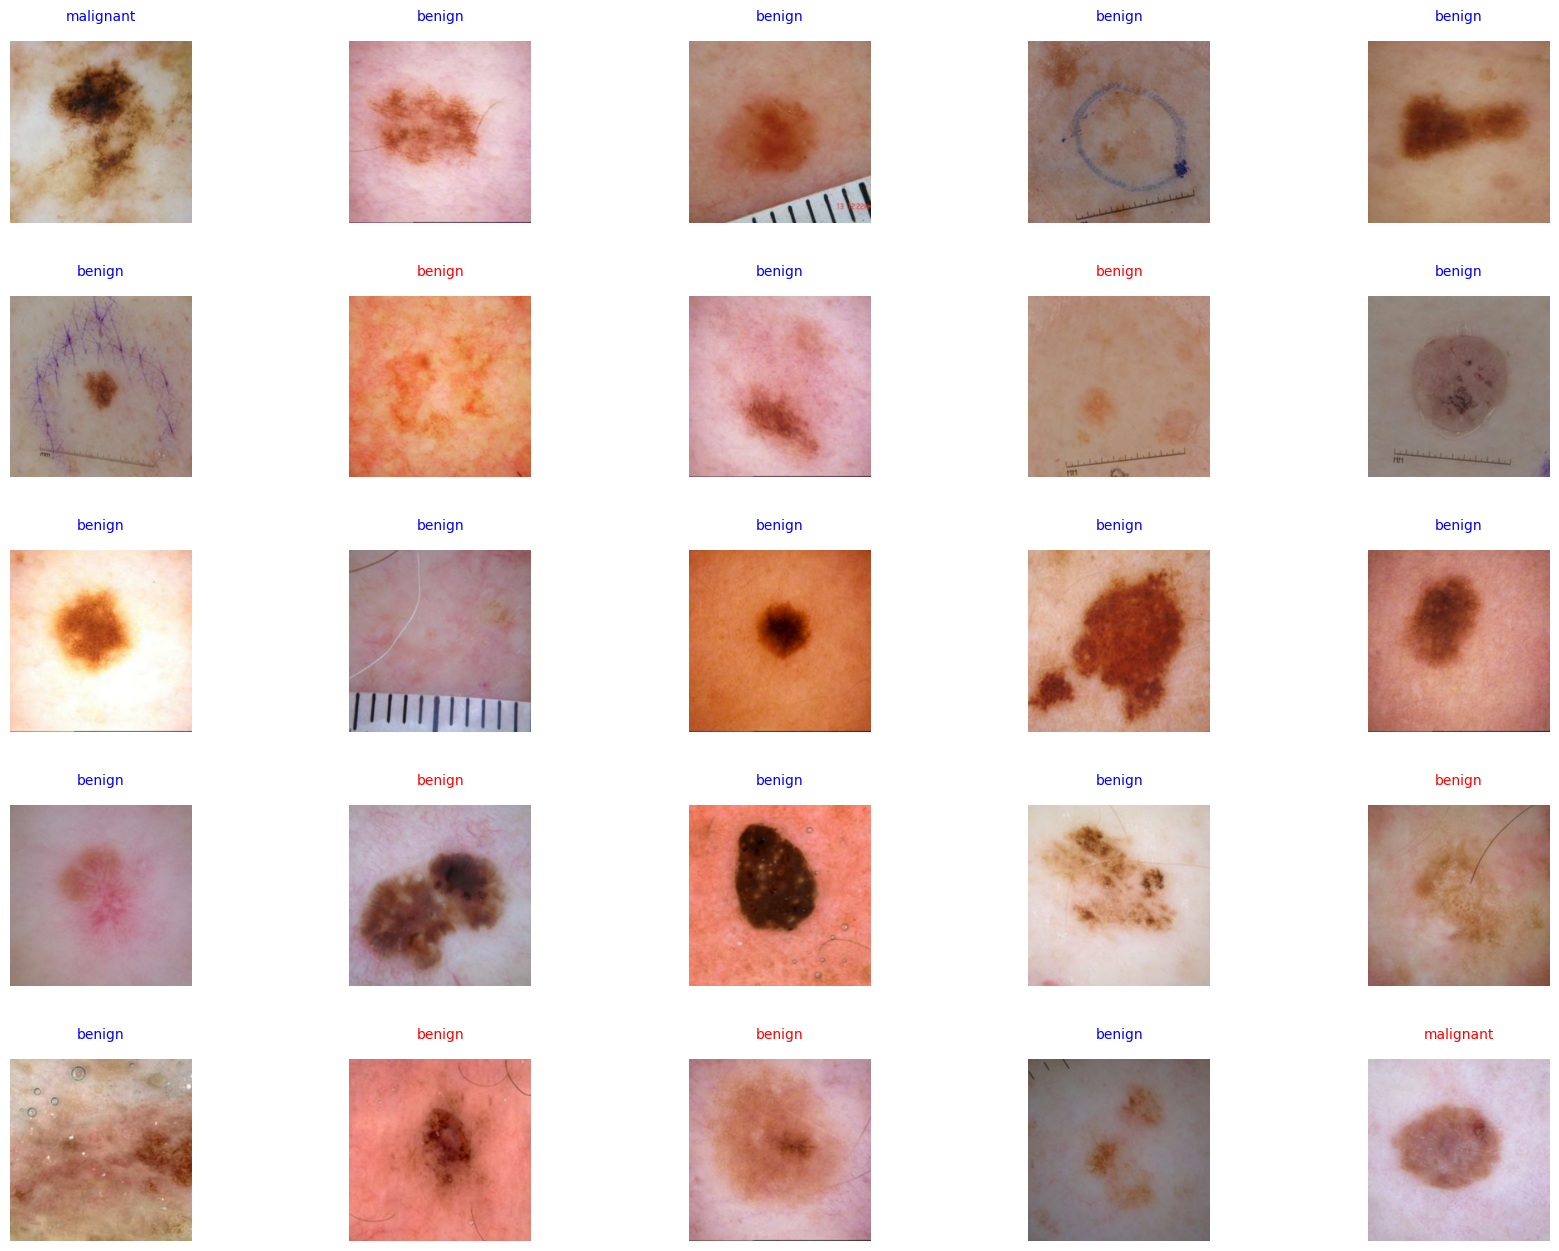

In [ ]:
plt.figure(figsize=(20, 15))
for images, labels in test_dataset.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)
        predict = model.predict(img2)
        predicted= class_names[np.argmax(predict)]
        actual = class_names [labels[i].numpy().astype("uint8")]
        if (actual == predicted):
            plt.title(predicted, fontsize=10, color= 'blue', pad=15);
        else :
            plt.title(actual, fontsize=10, color= 'red' ,pad=15);
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9,
                            top=0.9, wspace=0.4,hspace=0.4)

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset and make predictions
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Binarize the true and predicted labels
true_labels_bin = label_binarize(true_labels, classes=np.unique(true_labels))
predicted_labels_bin = label_binarize(predicted_labels, classes=np.unique(predicted_labels))


In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(report)


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Compute class-specific ROC AUC values
roc_auc_per_class = []
for i in range(len(class_names)):
    roc_auc = roc_auc_score(true_labels_bin[:, i], predicted_labels_bin[:, i])
    roc_auc_per_class.append(roc_auc)

# Plot class-specific ROC curves
plt.figure(figsize=(10, 8))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], predicted_labels_bin[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
##change the model name
plt.title('ROC Curves for Multiclass Classification of *model name*')
plt.legend(loc='lower right')
plt.show()

# Print class-specific ROC AUC values
for i in range(len(class_names)):
    print(f'ROC AUC for {class_names[i]}: {roc_auc_per_class[i]:.4f}')

In [ ]:

from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(true_labels, predicted_labels)
print(f'Cohen\'s Kappa: {kappa:.4f}')

In [ ]:
from sklearn.metrics import matthews_corrcoef
import numpy as np

# Assuming true_labels and predicted_labels are multiclass labels
mcc_values = [matthews_corrcoef(true_labels == i, predicted_labels == i) for i in np.unique(true_labels)]

average_mcc = np.mean(mcc_values)
print(f'Average Matthews Correlation Coefficient for Multiclass: {average_mcc:.4f}')


In [ ]:


# Calculate total right and wrong predictions
total_right = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
total_wrong = sum(1 for true, pred in zip(true_labels, predicted_labels) if true != pred)
total_samples = len(true_labels)

# Calculate wrong prediction percentage
wrong_prediction_percentage = (total_wrong / total_samples) * 100

print("Total Right Predictions:", total_right)
print("Total Wrong Predictions:", total_wrong)
print("Wrong Prediction Percentage: {:.2f}%".format(wrong_prediction_percentage))


In [ ]:
# Prepare data for plotting
categories = ['Right Predictions', 'Wrong Predictions']
values = [total_right, total_wrong]

# Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(categories, values, color=['green', 'red'])
plt.ylabel('Count')
plt.title('Right and Wrong Predictions')

# Show counts on top of the bars
for i, v in enumerate(values):
    plt.text(i, v + 0.1, str(v), ha='center', fontweight='bold')

plt.show()